In [1]:
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
import numpy as np

print("TensorFlow version is: {}".format(tf.__version__))
print("Eager execution is: {}".format(tf.executing_eagerly()))
print("Keras version is: {}".format(tf.keras.__version__))

TensorFlow version is: 2.2.0
Eager execution is: True
Keras version is: 2.3.0-tf


In [2]:
def read_labels(labels_path):
    with open(labels_path) as f:
        labels = f.readlines()
    labels = [c.strip() for c in labels]
    return labels

In [3]:
labels = read_labels('coco.txt')
labels[:5]

['person', 'bicycle', 'car', 'motorbike', 'aeroplane']

In [4]:
import colorsys
import random

def generate_colors(class_names):
    hsv_tuples = [(x / len(class_names), 1., 1.) for x in range(len(class_names))]
    colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
    colors = list(map(lambda x: (int(x[0] ), int(x[1] ), int(x[2] )), colors))
    random.seed(10101)  # Fixed seed for consistent colors across runs.
    random.shuffle(colors)  # Shuffle colors to decorrelate adjacent classes.
    random.seed(None)  # Reset seed to default.
    return colors

In [5]:
from matplotlib import pyplot
from matplotlib.patches import Rectangle

def draw_preds_bbs(file_name, preds_pipeline, is_coreml = False):
    print(preds_pipeline[0].shape)
    print(preds_pipeline[1].shape)
    boxes = preds_pipeline[0]
    scores = preds_pipeline[1]
#     boxes = preds_pipeline[2]

    print('start drawing boxes')
    data = pyplot.imread(file_name)
    ax = pyplot.gca()
    colors = generate_colors(labels)
    for i in range(len(boxes)):
        index = i # nms_ids[i]
        box = boxes[index]
#         w_h_box = w_h_boxes[i]
        class_id = np.argmax(scores[i])
        score = scores[i][class_id]

#         y1, x1, y2, x2 = box[0], box[1], box[2], box[3]
#         width, height = x2 - x1, y2 - y1
        if is_coreml == False :
            x1, y1, height, width = box[0], box[1], box[2], box[3]
        else:
            x1, y1, width, height = box[0], box[1], box[2], box[3]
        
#         width, height = x2 - x1, y2 - y1
        
#         rect = Rectangle(
#             (x1 * image_w, y1 * image_h),
#             width * image_w,
#             height * image_h,
#             fill=False,
#             color=colors[class_id]
#         )
        x1, y1, width, height = box[0], box[1], box[2], box[3]
#         x1, y1, x2, y2 = box[0], box[1], box[2], box[3]
#         w_x1, w_y1, w_width, w_height = w_h_box[0], w_h_box[1], w_h_box[2], w_h_box[3]
        
        
        
        
        
#         width = x2-x1
#         height = y2-y1
        
#         print(f'-- n -- x0 = {x1}, y0 ={y1}, w = {width}, h ={height}')
#         print(f'-- w -- x0 = {w_x1}, y0 ={w_y1}, w = {w_width}, h ={w_height}')
#         width = w_width
#         height = w_height
        rect = Rectangle(
            (x1 * image_w, y1 * image_h),
            width * image_w,
            height * image_h,
            fill=False,
            color=colors[class_id]
        )
        ax.add_patch(rect)
        label = "%s (%.3f)" % (labels[class_id], score*100)
        pyplot.text(
            x1* image_w,
            y1* image_h,
            label, 
            color= 'white'
        )
    pyplot.imshow(data)
    pyplot.show()

In [6]:
import coremltools as ct

In [7]:
yolo_tiny_model = load_model('yolov4-tiny-608-4thJun')

In [8]:
yolo_tiny_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 608, 608, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 609, 609, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 304, 304, 32) 864         zero_padding2d[0][0]             
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 304, 304, 32) 128         conv2d[0][0]                     
______________________________________________________________________________________________

In [18]:
yolo_tiny_model.outputs

[<tf.Tensor 'tf_op_layer_concat_14/Identity:0' shape=(None, None, None) dtype=float32>]

In [19]:
# yolo_tiny_model = load_model('yolov4-tiny-608-1stJun')

image_input = ct.ImageType(shape=(1,608, 608, 3), scale =1/255.0)

coreml_model = ct.convert(yolo_tiny_model, inputs=[image_input], outputs=['Identity:0'], source= 'tensorflow')

Translating MIL ==> MLModel Ops: 100%|█████| 486/486 [00:01<00:00, 471.67 ops/s]


In [20]:
spec= coreml_model.get_spec()
spec.description

input {
  name: "input_1"
  type {
    imageType {
      width: 608
      height: 608
      colorSpace: RGB
    }
  }
}
output {
  name: "Identity:0"
  type {
    multiArrayType {
      dataType: FLOAT32
    }
  }
}
metadata {
  userDefined {
    key: "com.github.apple.coremltools.source"
    value: "tensorflow==2.2.0"
  }
  userDefined {
    key: "com.github.apple.coremltools.version"
    value: "4.0b3"
  }
}

In [ ]:
ma_type = spec.description.output[0].type.multiArrayType
ma_type.shapeRange.sizeRanges.add()
ma_type.shapeRange.sizeRanges[0].lowerBound = 1
ma_type.shapeRange.sizeRanges[0].upperBound = 2
ma_type.shapeRange.sizeRanges.add()
ma_type.shapeRange.sizeRanges[1].lowerBound = 0
ma_type.shapeRange.sizeRanges[1].upperBound = -1
ma_type.shapeRange.sizeRanges.add()
ma_type.shapeRange.sizeRanges[2].lowerBound = 84
ma_type.shapeRange.sizeRanges[2].upperBound = 84

In [ ]:
spec.description

In [ ]:
detector_builder = ct.models.neural_network.NeuralNetworkBuilder(spec= spec)

In [ ]:
detector_builder.set_output(output_names=['Identity',], output_dims=[(0,0,84),] )

In [ ]:
yolo_coreml_model_modified = ct.models.MLModel(detector_builder.spec)

In [ ]:
print(yolo_coreml_model_modified)

In [ ]:
decoder = ct.models.MLModel('decoder_yolo_coreml_model_modified.mlmodel')

In [ ]:
print(decoder)

In [10]:
from PIL import Image
def load_local_and_scale_image(image_path, shape):
    image = Image.open(image_path)
    return image.resize(shape)

In [11]:
input_w, input_h = 608, 608
photo_filename = '/Users/ankit/Desktop/test_image_samples/croc.jpeg'
# photo_filename = 'empty_image.jpg'
image = Image.open(photo_filename)
image_w = image.size[0]
image_h = image.size[1]
# image, image_w, image_h = load_image_pixels(photo_filename, (input_w, input_h))
print("image initial size: ", image_w, image_h)

image initial size:  275 183


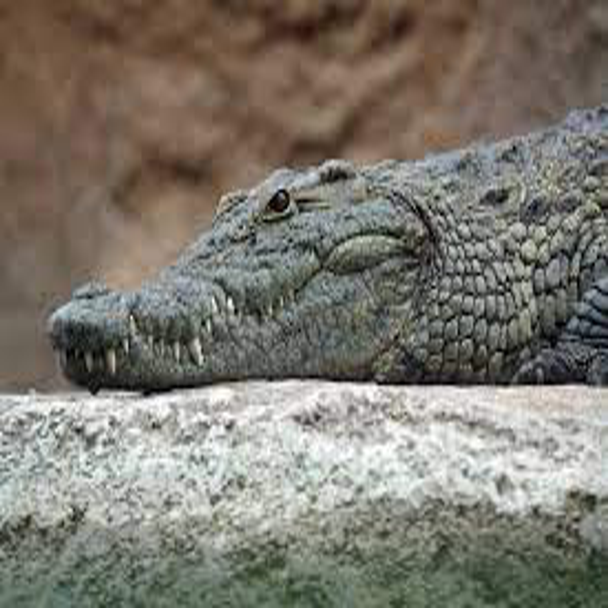

In [21]:
test_image = load_local_and_scale_image(photo_filename, (608, 608)) 
test_image

In [22]:
preds = coreml_model.predict(data={'input_1': test_image},)

RuntimeError: {
    NSLocalizedDescription = "Error computing NN outputs.";
}

In [ ]:
preds

In [ ]:
draw_preds_bbs(
    photo_filename, 
    [
        preds['Identity'],
        preds['Identity_1'],
        
    ],
    is_coreml=True
)